## Hard Drive Failure Prediction: Backblaze Data Center
### Stage 1: Model Building using model ST4000DM000 for year 2017

In [ ]:
import requests
import os
import time

In [ ]:
os.getcwd() #Intial data root

'C:\\Users\\jahmed'

In [ ]:
os.chdir('C:\\Users\\jahmed\Desktop\\Jishan\PhDResearch\\Code')

In [ ]:
os.getcwd() #Intial data root

'C:\\Users\\jahmed\\Desktop\\Jishan\\PhDResearch\\Code'

### Required packages

In [ ]:
%matplotlib inline
#plt.style.use('seaborn')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import pickle

#set matplotlib parameters

sns.set_style('white')
plt.rcParams['axes.grid'] = True
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['grid.color'] = 'k'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [ ]:
#import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# import needed libraries and get data from external
import pandas as pd
import numpy as np
from numpy import NaN, NAN, nan
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFECV
from sklearn import preprocessing

## Data load and pre-processing

In [ ]:
start_time1 = time.time()
cwd = os.getcwd()
df = pd.concat([pd.read_csv(f, header=0,sep='\t') for f in glob.glob(cwd + '/FinalData/2017-ST4000DM000/*.csv')], ignore_index=True)
df.head()
end_time1 = time.time()
print ("Data load time in seconds = " +str(end_time1 - start_time1) )
        

Data load time in seconds = 11.950889110565186


In [ ]:
df.shape

(12546763, 10)

In [ ]:
df.shape

(12546763, 10)

In [ ]:
# determine the failure_count of each model in entire dataset
master_df=df
failure_counts = master_df[master_df["failure"]==1].groupby(["model"]).agg({'model':'count'})
failure_counts.columns = ["Failed_count"]
failure_counts['Model_name'] = failure_counts.index
failure_counts = failure_counts.reset_index(drop=True)
failure_counts.shape

(2, 2)

In [ ]:
# determine the no_failure_count of each model in entire dataset
no_failure_counts = master_df[master_df["failure"]==0].groupby(["model"]).agg({'model':'count'})
no_failure_counts.columns = ["Healthy_count"]
no_failure_counts['Model_name'] = no_failure_counts.index
no_failure_counts = no_failure_counts.reset_index(drop=True)
no_failure_counts.shape

(2, 2)

In [ ]:
# determine the count of each model in entire dataset
models_count = master_df["model"]
models_count = models_count.value_counts().to_frame()
models_count.columns = ["Total_count"]
models_count['Model_name'] = models_count.index
models_count.reset_index(drop=True)
models_count.shape

(2, 2)

In [ ]:

# combine no_failure_counts and failure_counts into one df
merged_level_1 = pd.merge(no_failure_counts, failure_counts, left_on='Model_name', right_on='Model_name', how="left")
merged_level_1

,Healthy_count,Model_name,Failed_count
0,308847,ST12000NM0007,17
1,12236835,ST4000DM000,1064


In [ ]:

# combine models_count and failure_counts into one df
merged_level_2 = pd.merge(models_count, merged_level_1, left_on='Model_name', right_on='Model_name', how="left")
merged_level_2 = merged_level_2.fillna(0)
merged_level_2["Failed_count"] = merged_level_2["Failed_count"].astype('int32')
merged_level_2 = merged_level_2.sort_values(by='Failed_count', ascending=False).head(5)
merged_level_2

,Total_count,Model_name,Healthy_count,Failed_count
0,12237899,ST4000DM000,12236835,1064
1,308864,ST12000NM0007,308847,17


In [ ]:
merged_level_2["Failed_percentage"] = (merged_level_2["Failed_count"] / merged_level_2["Total_count"])*100
merged_level_2.head()

,Total_count,Model_name,Healthy_count,Failed_count,Failed_percentage
0,12237899,ST4000DM000,12236835,1064,0.008694
1,308864,ST12000NM0007,308847,17,0.005504


In [ ]:
num_drives = len(df.serial_number.unique()) # unique hard drives in 1Q19
print('{} unique hard drives in use in 2Q19.'.format(num_drives))
print('---------------------------------------------------------- \n')

print('Percentage of each model in the dataset. \n')
model_pcts = df.groupby('model').serial_number.nunique().sort_values(ascending=False) / num_drives * 100.0
print('{}%'.format(round(model_pcts, 2)))
print('---------------------------------------------------------- \n')

print('The top 5 models comprise {}% of the total.'.format(round(model_pcts.head(5).sum(), 2)))
print('---------------------------------------------------------- \n')

model_pcts = model_pcts.reset_index() # bring index of models into dataframe to fitler by model
ST = model_pcts[(model_pcts.model.str.startswith('ST'))].sum()[-1]
HGST = model_pcts[(model_pcts.model.str.startswith('HGST'))].sum()[-1]
print('ST and HGST models comprise: {}% of the total.'.format(round((ST + HGST), 2)))
print('---------------------------------------------------------- \n')
print('ST comprise: {}%'.format(round(ST/100 * 100, 2)))
print('HGST comprise: {}%'.format(round(HGST/100 * 100, 2)))   
print('Others comprise: {}%'.format(round((1 - ST/100 - HGST/100) * 100, 2)))

42431 unique hard drives in use in 2Q19.
---------------------------------------------------------- 

Percentage of each model in the dataset. 

model
ST4000DM000      82.93
ST12000NM0007    17.07
Name: serial_number, dtype: float64%
---------------------------------------------------------- 

The top 5 models comprise 100.0% of the total.
---------------------------------------------------------- 

ST and HGST models comprise: 100.0% of the total.
---------------------------------------------------------- 

ST comprise: 100.0%
HGST comprise: 0.0%
Others comprise: 0.0%


##### How complete is the dataset, are there missing values (nan)?

From the printout below, we can see that a large percentage of some columns are missing values. In some cases the entire column is missing (e.g., smart_13 and smart_15).

In [ ]:
for column in list(df):
    missing = round(df[column].notna().sum() / df.shape[0] * 100, 2)
    print('{:.<27}{}%'.format(column, missing))

model......................100.0%
date.......................100.0%
serial_number..............100.0%
capacity_bytes.............100.0%
failure....................100.0%
smart_5_raw................100.0%
smart_187_raw..............100.0%
smart_188_raw..............100.0%
smart_197_raw..............100.0%
smart_198_raw..............100.0%


In [ ]:
def print_df_percent_missing(df_passed):
    col_names = list(df_passed.columns.values)
    tuples_of_missing = []
    num_rows = df_passed.shape[0]


    i = 0
    for value in df_passed.count():
        tuples_of_missing.append((col_names[i], value))
        i+=1

    tuples_of_missing.sort(key=lambda pair: pair[1], reverse=False)

    i = 1
    for key, value in tuples_of_missing: 
        percent_missing = 100 - (value / num_rows * 100)
        print(key.ljust(30),  str(f'{percent_missing:.2f}' + '%').ljust(6) + " Missing   " + str(i))
        i += 1

In [ ]:
print_df_percent_missing(df)

smart_5_raw                    0.00%  Missing   1
smart_187_raw                  0.00%  Missing   2
smart_188_raw                  0.00%  Missing   3
smart_197_raw                  0.00%  Missing   4
smart_198_raw                  0.00%  Missing   5
model                          0.00%  Missing   6
date                           0.00%  Missing   7
serial_number                  0.00%  Missing   8
capacity_bytes                 0.00%  Missing   9
failure                        0.00%  Missing   10


Number of observations before filtering: 12546763
---------------------------------------------------------- 

Number of observations after filtering: 12546763
---------------------------------------------------------- 

Percentage change in observations after filtering:  0.0%
---------------------------------------------------------- 



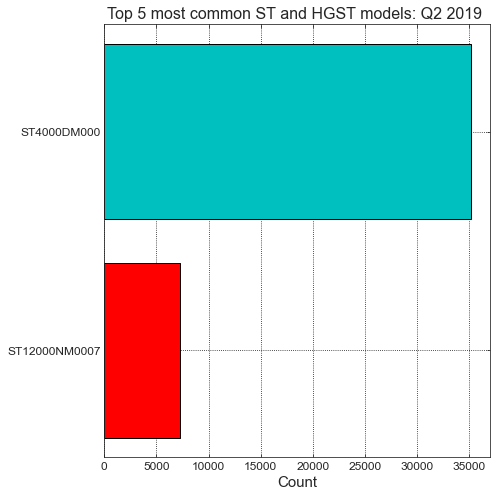

Missing percentages in the new dataset: 

smart_5_raw                    0.00%  Missing   1
smart_187_raw                  0.00%  Missing   2
smart_188_raw                  0.00%  Missing   3
smart_197_raw                  0.00%  Missing   4
smart_198_raw                  0.00%  Missing   5
model                          0.00%  Missing   6
date                           0.00%  Missing   7
serial_number                  0.00%  Missing   8
capacity_bytes                 0.00%  Missing   9
failure                        0.00%  Missing   10


In [ ]:
n_rows_before = df.shape[0]
print('Number of observations before filtering:', n_rows_before)
print('---------------------------------------------------------- \n')

# filter by brands, and then select top ten ST and HGST models
brand_filter = (df['model'].str.startswith('ST')) | (df['model'].str.startswith('HGST')) # ST and HGST brands boolean mask
df = df[brand_filter]
model_filter = df.groupby('model').size().sort_values(ascending=False).head(5).index # find top ten models
model_filter = list(model_filter)
model_filter = df['model'].isin(model_filter) # build the boolean mask
df = df[model_filter]

n_rows_after = df.shape[0]
print('Number of observations after filtering:', n_rows_after)
print('---------------------------------------------------------- \n')
print('Percentage change in observations after filtering:  {}%'.format(round((n_rows_after / n_rows_before - 1) * 100 , 2)))
print('---------------------------------------------------------- \n')
# plot counts of hard drives by model
fig, ax = plt.subplots(figsize=(7, 7))
# Set the colors
colors = [ 'r', 'c', 'm', 'y', 'g']
ax.barh(df.groupby('model').serial_number.nunique().sort_values().index, df.groupby('model').serial_number.nunique().sort_values(),color=colors, edgecolor='k')
ax.set_xlabel('Count')
ax.set_title('Top 5 most common ST and HGST models: Q2 2019 ', size=16)

plt.tight_layout()
plt.show()

print('Missing percentages in the new dataset: \n')
print_df_percent_missing(df)

In [ ]:
n_fail = df.failure.sum() # number of drives failed in 1Q19
n_notfail = len(df.serial_number.unique()) - n_fail
ptg_fail = (n_fail / (n_notfail+ n_fail) )*100

print('No. of failed drives in 1Q19: {} '.format(n_fail))
print('No. of healthy drives in 1Q19: {} '.format(n_notfail))
print('Percentage of failed: {:.2f}%'.format(round(ptg_fail,2)))

No. of failed drives in 1Q19: 1081 
No. of healthy drives in 1Q19: 41350 
Percentage of failed: 2.55%


In [ ]:
df.failure.value_counts(normalize = True)

0    0.999914
1    0.000086
Name: failure, dtype: float64

In [ ]:
#determine number of unique models in data
print(f'There are {df.model.nunique()} unique model types')

There are 2 unique model types


In [ ]:
#Determine how many models in this data have failed
failing_models = df[df.failure == 1]['model']

print(f'There are {failing_models.nunique()} model types that have failed')
failing_models.value_counts(ascending = True)

There are 2 model types that have failed


ST12000NM0007      17
ST4000DM000      1064
Name: model, dtype: int64

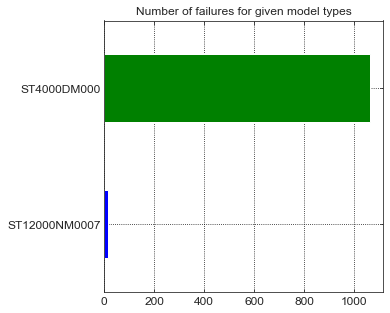

In [ ]:
%matplotlib inline

fig = plt.figure(figsize = (5,5))
colors = ['b', 'g', 'r', 'c', 'm']
#plot the model types that have failed
ax = failing_models.value_counts(ascending = True).plot.barh(color=colors)
ax.set_title('Number of failures for given model types')
plt.savefig('model_failures.png')
plt.show();

In [ ]:
x3 = df[['model', 'failure']].groupby('model').count() # Total number of each model
x3

,failure
model,
ST12000NM0007,308864
ST4000DM000,12237899


In [ ]:
df.columns

Index(['model', 'date', 'serial_number', 'capacity_bytes', 'failure',
       'smart_5_raw', 'smart_187_raw', 'smart_188_raw', 'smart_197_raw',
       'smart_198_raw'],
      dtype='object')

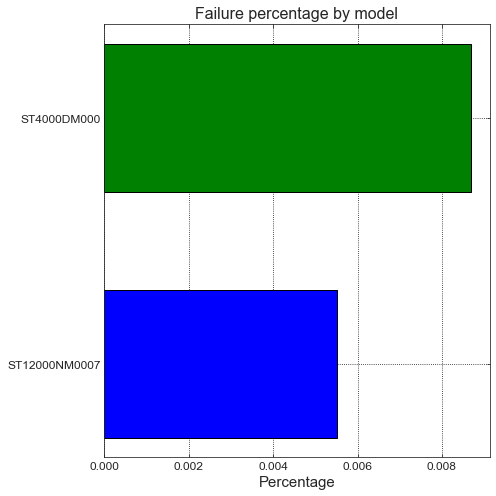

In [ ]:
x1 = df[['model', 'failure']].groupby('model').sum() # Total number of failures by model
x2 = df[['model', 'failure']].groupby('model').count() # Total number of each model
ptg_model_fail = np.divide(x1, x2) * 100 
ptg_model_fail.columns = ['ptg']
ptg_model_fail = ptg_model_fail.reset_index().sort_values('ptg')
# Set the colors
colors = ['b', 'g', 'r', 'c', 'm']
fig, ax = plt.subplots(figsize=(7, 7))
ax.barh(ptg_model_fail['model'], ptg_model_fail['ptg'], color=colors,edgecolor='k',height=0.6)
ax.set_xlabel('Percentage')
ax.set_title('Failure percentage by model', size=16)

plt.tight_layout()
plt.show()

In [ ]:
df.shape

(12546763, 10)

In [ ]:
df_2Q19 = df[(df.model == 'ST4000DM000')] 
df.date = pd.to_datetime(df.date)

In [ ]:
df_2Q19.shape

(12237899, 10)

In [ ]:
df_2Q19.head(5)

,model,date,serial_number,capacity_bytes,failure,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw
0,ST4000DM000,2017-01-01,Z305B2QN,4 Tb,0,0.0,0.0,0.0,0.0,0.0
1,ST4000DM000,2017-01-01,Z302A0YH,4 Tb,0,0.0,0.0,1.0,0.0,0.0
2,ST4000DM000,2017-01-01,Z305BT0W,4 Tb,0,0.0,0.0,0.0,0.0,0.0
3,ST4000DM000,2017-01-01,Z302A0YE,4 Tb,0,0.0,0.0,0.0,0.0,0.0
4,ST4000DM000,2017-01-01,Z302PGH8,4 Tb,0,0.0,0.0,0.0,0.0,0.0


In [ ]:
failure=df_2Q19[df_2Q19["failure"] != 0]
failure.shape

(1064, 10)

In [ ]:
failureBySize =failure[['capacity_bytes','failure']].groupby('capacity_bytes').count() # Total number of each model
failureBySize.reset_index().sort_values('failure', ascending=False)

,capacity_bytes,failure
1,4 Tb,1061
0,0 Tb,3


In [ ]:
neg, pos = np.bincount(df_2Q19['failure'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 12237899
    Positive: 1064 (0.01% of total)



In [ ]:
#determine number of unique models in data
print(f'There are {df_2Q19.model.nunique()} unique model types')
#Determine how many models in this data have failed
failing_models = df[df.failure == 1]['model']

print(f'There are {failing_models.nunique()} model types that have failed in the original')
failing_models.value_counts(ascending = True)
failing_models2 = df_2Q19[df_2Q19.failure == 1]['model']

print(f'There are {failing_models2.nunique()} model types that have failed in the reduced set')
failing_models2.value_counts(ascending = True)

There are 1 unique model types
There are 2 model types that have failed in the original
There are 1 model types that have failed in the reduced set


ST4000DM000    1064
Name: model, dtype: int64

In [ ]:
reduced_columns = df_2Q19[['model', 'date','serial_number','capacity_bytes','failure','smart_5_raw', 'smart_187_raw','smart_188_raw','smart_197_raw','smart_198_raw']]

In [ ]:
reduced_columns.isnull().sum()

model               0
date                0
serial_number       0
capacity_bytes      0
failure             0
smart_5_raw       202
smart_187_raw     202
smart_188_raw     202
smart_197_raw     202
smart_198_raw     202
dtype: int64

In [ ]:
reduced_columns.isnull().sum()

model               0
date                0
serial_number       0
capacity_bytes      0
failure             0
smart_5_raw       202
smart_187_raw     202
smart_188_raw     202
smart_197_raw     202
smart_198_raw     202
dtype: int64

In [ ]:
reduced_columns.dtypes

model              object
date               object
serial_number      object
capacity_bytes     object
failure             int64
smart_5_raw       float64
smart_187_raw     float64
smart_188_raw     float64
smart_197_raw     float64
smart_198_raw     float64
dtype: object

In [ ]:
reduced_columns.memory_usage(deep=True)

Index              97903192
model             832177132
date              819939233
serial_number     795463435
capacity_bytes    746512038
failure            97903192
smart_5_raw        97903192
smart_187_raw      97903192
smart_188_raw      97903192
smart_197_raw      97903192
smart_198_raw      97903192
dtype: int64

In [ ]:
low_memory_df = reduced_columns.copy()

In [ ]:
low_memory_df["failure"] = low_memory_df["failure"].astype("category")
low_memory_df[["smart_5_raw", "smart_187_raw","smart_188_raw","smart_197_raw","smart_198_raw"]] = low_memory_df[["smart_5_raw", "smart_187_raw","smart_188_raw","smart_197_raw","smart_198_raw"]].apply(pd.to_numeric, downcast="float")

In [ ]:
low_memory_df.memory_usage(deep=True)

Index              97903192
model             832177132
date              819939233
serial_number     795463435
capacity_bytes    746512038
failure            12237995
smart_5_raw        48951596
smart_187_raw      48951596
smart_188_raw      48951596
smart_197_raw      48951596
smart_198_raw      48951596
dtype: int64

In [ ]:
low_memory_df.dtypes

model               object
date                object
serial_number       object
capacity_bytes      object
failure           category
smart_5_raw        float32
smart_187_raw      float32
smart_188_raw      float32
smart_197_raw      float32
smart_198_raw      float32
dtype: object

In [ ]:
reduction = low_memory_df.memory_usage(deep=True).sum() /reduced_columns.memory_usage(deep=True).sum()
print(f"{reduction:0.2f}")


0.91


### Final dataframe

In [ ]:
reduced_columns.to_csv('C:\\Users\\jahmed\\Desktop\\Jishan\\PhDResearch\\Code\\FinalData\\ST4000DM000_2017.csv',encoding='utf-8',sep='\t', index=False)
    

In [ ]:
reduced_columns.shape

(12237899, 10)

In [ ]:
reduced_columns.head()

,model,date,serial_number,capacity_bytes,failure,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw
0,ST4000DM000,2017-01-01,Z305B2QN,4 Tb,0,0.0,0.0,0.0,0.0,0.0
1,ST4000DM000,2017-01-01,Z302A0YH,4 Tb,0,0.0,0.0,1.0,0.0,0.0
2,ST4000DM000,2017-01-01,Z305BT0W,4 Tb,0,0.0,0.0,0.0,0.0,0.0
3,ST4000DM000,2017-01-01,Z302A0YE,4 Tb,0,0.0,0.0,0.0,0.0,0.0
4,ST4000DM000,2017-01-01,Z302PGH8,4 Tb,0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df = reduced_columns[['smart_5_raw', 'smart_187_raw','smart_188_raw','smart_197_raw','smart_198_raw','failure']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12237899 entries, 0 to 12546762
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   failure        int64  
 1   smart_5_raw    float64
 2   smart_187_raw  float64
 3   smart_188_raw  float64
 4   smart_197_raw  float64
 5   smart_198_raw  float64
dtypes: float64(5), int64(1)
memory usage: 653.6 MB


In [ ]:
df['failure'].unique()

array([0, 1], dtype=int64)

In [ ]:
np.any(np.isnan(df))

True

In [ ]:
np.any(np.isnan(df))

True

In [ ]:
print("Columnwise total missing value\n",df.isnull().sum())

Columnwise total missing value
 smart_5_raw      202
smart_187_raw    202
smart_188_raw    202
smart_197_raw    202
smart_198_raw    202
failure            0
dtype: int64


In [ ]:
# Missing percentage
df.isnull().sum() / df.shape[0] * 100.00

smart_5_raw      0.001651
smart_187_raw    0.001651
smart_188_raw    0.001651
smart_197_raw    0.001651
smart_198_raw    0.001651
failure          0.000000
dtype: float64

In [ ]:
df=df.dropna()

In [ ]:
# Missing percentage
df.isnull().sum() / df.shape[0] * 100.00

smart_5_raw      0.0
smart_187_raw    0.0
smart_188_raw    0.0
smart_197_raw    0.0
smart_198_raw    0.0
failure          0.0
dtype: float64

In [ ]:
np.all(np.isfinite(df))

True

In [ ]:
np.finfo(np.float64).max

1.7976931348623157e+308

In [ ]:
X = df.iloc[:,:-1]
y = df['failure'] # BP_df_cp.iloc[:,-1:]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


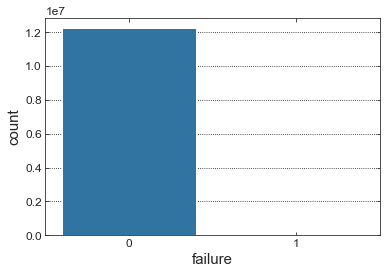

In [ ]:
sns.countplot(Y,label="failure")
plt.show()

In [ ]:
neg, pos = np.bincount(df['failure'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 12237697
    Positive: 1061 (0.01% of total)



### Base models without re-sampling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)

In [ ]:
LR = LogisticRegression()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LR, X_train, y_train, scoring=scoring, cv=5)

sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [ ]:
# Decision Tree
decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train, y_train, scoring=scoring, cv=5)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()

In [ ]:
# Linear Discriminant Analysis
LDA = LinearDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LDA, X_train, y_train, scoring=scoring, cv=5)

sorted(scores.keys())
LDA_fit_time = scores['fit_time'].mean()
LDA_score_time = scores['score_time'].mean()
LDA_accuracy = scores['test_accuracy'].mean()
LDA_precision = scores['test_precision_macro'].mean()
LDA_recall = scores['test_recall_macro'].mean()
LDA_f1 = scores['test_f1_weighted'].mean()
LDA_roc = scores['test_roc_auc'].mean()

In [ ]:
# Quadratic Discriminant Analysis
QDA = QuadraticDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(QDA, X_train, y_train, scoring=scoring, cv=5)

sorted(scores.keys())
QDA_fit_time = scores['fit_time'].mean()
QDA_score_time = scores['score_time'].mean()
QDA_accuracy = scores['test_accuracy'].mean()
QDA_precision = scores['test_precision_macro'].mean()
QDA_recall = scores['test_recall_macro'].mean()
QDA_f1 = scores['test_f1_weighted'].mean()
QDA_roc = scores['test_roc_auc'].mean()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# Random Forest Classifier
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train, y_train, scoring=scoring, cv=5)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()

In [ ]:
# Naive Bayes
bayes = GaussianNB()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(bayes, X_train, y_train, scoring=scoring, cv=5)

sorted(scores.keys())
bayes_fit_time = scores['fit_time'].mean()
bayes_score_time = scores['score_time'].mean()
bayes_accuracy = scores['test_accuracy'].mean()
bayes_precision = scores['test_precision_macro'].mean()
bayes_recall = scores['test_recall_macro'].mean()
bayes_f1 = scores['test_f1_weighted'].mean()
bayes_roc = scores['test_roc_auc'].mean()

In [ ]:
models_initial = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest', 'Bayes'],
    'Fitting time': [LR_fit_time, dtree_fit_time, LDA_fit_time, QDA_fit_time, forest_fit_time, bayes_fit_time],
    'Scoring time': [LR_score_time, dtree_score_time, LDA_score_time, QDA_score_time, forest_score_time, bayes_score_time],
    'Accuracy'    : [LR_accuracy, dtree_accuracy, LDA_accuracy, QDA_accuracy, forest_accuracy, bayes_accuracy],
    'Precision'   : [LR_precision, dtree_precision, LDA_precision, QDA_precision, forest_precision, bayes_precision],
    'Recall'      : [LR_recall, dtree_recall, LDA_recall, QDA_recall, forest_recall, bayes_recall],
    'F1_score'    : [LR_f1, dtree_f1, LDA_f1, QDA_f1, forest_f1, bayes_f1],
    'AUC_ROC'     : [LR_roc, dtree_roc, LDA_roc, QDA_roc, forest_roc, bayes_roc],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC'])

models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC
0,Logistic Regression,63.587061,1.458813,0.999911,0.708520,0.518839,0.999875,0.797290
4,Random Forest,145.934832,17.775146,0.999910,0.669418,0.519791,0.999874,0.616804
1,Decision Tree,2.953686,1.623610,0.999909,0.674786,0.528253,0.999876,0.477693
2,Linear Discriminant Analysis,3.757386,1.556169,0.998893,0.512718,0.640802,0.999363,0.804645
5,Bayes,1.220925,1.998990,0.994507,0.503780,0.736493,0.997161,0.804599
3,Quadratic Discriminant Analysis,1.415452,2.012822,0.992103,0.502806,0.744671,0.995950,0.804801


In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
yPred = model.predict(X_test)
print("Full model F1 score for test data: ", f1_score(yPred,y_test))


Full model F1 score for test data:  0.08798646362098139


## Cost sensitive Random Forest 

In [ ]:

# class balanced random forest for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# define model
model = RandomForestClassifier(n_estimators=10, class_weight='balanced')
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, Y, scoring='f1', cv=cv, n_jobs=-1)
# summarize performance
print('Mean F1 score: %.3f' % mean(scores))

Mean F1 score: 0.004


##  Cost-Sensitive Neural Network 

In [ ]:
#X_train, X_test, y_train, y_test
 
# define the neural network model
def define_model(n_input):
# define model
    model = Sequential()
# define first hidden layer and visible layer
    model.add(Dense(10, input_dim=n_input, activation='relu', kernel_initializer='he_uniform'))
# define output layer
    model.add(Dense(1, activation='sigmoid'))
# define loss and optimizer
    model.compile(loss='binary_crossentropy', optimizer='sgd')
    return model
 
# get the model
n_input = X_train.shape[1]
model = define_model(n_input)
# fit model
weights = {0:1, 1:100}
history = model.fit(X_train,  y_train, class_weight=weights, epochs=100, verbose=0)
# evaluate model
yhat = model.predict(X_test)
score = f1_score(y_test, yhat)
print('F1: %.3f' % score)

KeyboardInterrupt: 